首先，说明自己使用的库名、库类型与模块等，本代码所使用的主要如下：

In [1]:
import numpy as np
import random
from PIL import Image
import os
import re
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


之后，开始按照自己的习惯把算法分解成为可理解的若干分块。在这个过程中，发现有许多步骤需要将图片转换为二值矩阵或者其逆操作等，故先写几个函数便于调用。
下面这个函数用于将jpg格式或者jpeg格式的图片转换为二值矩阵。先生成x这个全零矩阵，从而将imgArray中的色度值分类，获得最终的二值矩阵。这个函数在全文中将多次调用。


In [2]:
def readImg2array(file,size, threshold= 100):
    #file is jpg or jpeg pictures
    #size is a 1*2 vector,eg (40,40)
    pilIN = Image.open(file).convert(mode="L")
    pilIN= pilIN.resize(size)
    #pilIN.thumbnail(size,Image.ANTIALIAS)
    imgArray = np.asarray(pilIN,dtype=np.uint8)
    x = np.zeros(imgArray.shape,dtype=np.float)
    x[imgArray > threshold] = 1
    x[x==0] = -1
    return x


下面在定义的便是其逆变换，由于Python中已经有该逆变换的函数，故只是稍作加工便可使用。

In [3]:
def array2img(data, outFile = None):

    #data is 1 or -1 matrix
    y = np.zeros(data.shape,dtype=np.uint8)
    y[data==1] = 255
    y[data==-1] = 0
    img = Image.fromarray(y,mode="L")
    if outFile is not None:
        img.save(outFile)
    return img



写到这一步，已经可以输入原始图片获得该二值矩阵了。这里需要注意，选取图片时尽量选取黑白分明的图片以获得好的display, 可以调整size与threshold改变最后图片的对比度以及图片大小。

下面是另一个为了方便计算而编写的程序，利用x.shape得到矩阵x的每一维个数，从而得到m个元素的全零向量。将x按i\j顺序赋值给向量tmp1. 最后得到从矩阵转换的向量。

In [4]:
def mat2vec(x):
    #x is a matrix
    m = x.shape[0]*x.shape[1]
    tmp1 = np.zeros(m)

    c = 0
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            tmp1[c] = x[i,j]
            c +=1
    return tmp1


接下来便是非常重要的一步，创建H ij​,即权重矩阵，根据权重矩阵的定义J i j = 1 N ∑ μ = 1 p ξ i μ ξ j μ J{_{ij}}=\frac{1}{N}\sum_{\mu=1}^{p}\xi{^\mu_i}\xi{^\mu_j}J ij​= N1​∑μ=1p​ξ iμ​ξ jμ​	根据权重矩阵的对称特性，可以很好地减少计算量。
 



In [5]:
#use Hebbian rule create weight matrix
def create_W_single_pattern(x):
    # x is a vector
    if len(x.shape) != 1:
        print ("The input is not vector")
        return
    else:
        w = np.zeros([len(x),len(x)])
        for i in range(len(x)):
            for j in range(i,len(x)):
                if i == j:
                    w[i,j] = 0
                else:
                    w[i,j] = x[i]*x[j]
                    w[j,i] = w[i,j]
    return w


下一个需要建立的函数便是输入test picture之后对神经元的随机升级。利用异步更新，以及前面提到的迭代公式，从而获取更新后的神经元向量以及系统能量。

In [6]:
#randomly update
def update_asynch(weight,vector,theta=0.5,times=145):
    energy_ = []
    times_ = []
    energy_.append(energy(weight,vector))
    times_.append(0)
    for i in range(times):
        length = len(vector)
        update_num = random.randint(0,length-1)
        next_time_value = np.dot(weight[update_num][:],vector) - theta
        if next_time_value>=0:
            vector[update_num] = 1
        if next_time_value<0:
            vector[update_num] = -1
        times_.append(i)
        energy_.append(energy(weight,vector))
    
    return (vector,times_,energy_)
                


为了更好地看到迭代对系统的影响，我们按照定义计算每一次迭代后的系统能量，最后画出E的图像，便可验证前文的观点。

In [7]:
def energy(weight,x,bias=0):
#weight: m*m weight matrix
#x: 1*m data vector
#bias: outer field
    energy = -x.dot(weight).dot(x.T)+sum(bias*x)
    # E is a scalar
    return energy


定义完主要的函数之后，我们来到main body部分，调用前文定义的函数，便可简洁地把主函数表达清楚。可以调整size和threshod获得更好的输入效果，但是也有可能会增大计算机的计算量而增加运行时间。为了增加泛化能力，我们正则化之后打开训练图片，并且通过该程序获取权重矩阵。

In [8]:
#main 
#import training picture
size_global =(80,80)
threshold_global = 120

train_paths = []
train_path = "./women_train/"
for i in os.listdir(train_path):
    if re.match(r'[0-9 a-z A-Z-_]*.jp[e]*g',i):
        train_paths.append(train_path+i)
flag = 0
for path in train_paths:
    matrix_train = readImg2array(path,size = size_global,threshold=threshold_global)
    vector_train = mat2vec(matrix_train)
    plt.imshow(array2img(matrix_train))
    plt.title("train picture"+str(flag+1))
    plt.show()
    if flag == 0:
        w_ = create_W_single_pattern(vector_train)
        flag = flag +1
    else:
        w_ = w_ +create_W_single_pattern(vector_train)
        flag = flag +1

w_ = w_/flag
print("weight matrix is prepared!!!!!")
    


FileNotFoundError: [WinError 3] 系统找不到指定的路径。: './women_train/'

得到权重矩阵之后的第一步自然是输入测试图片，依然正则化之后，根据图片-矩阵-图片的方式，将测试图片转换为二值图像如下图所示。

<AxesSubplot:>

Text(0.5, 1.0, 'test picture1')

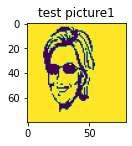

In [9]:
## import test data
test_paths = []
test_path = "./women_test/"
for i in os.listdir(test_path):
    if re.match(r'[0-9 a-z A-Z-_]*.jp[e]*g',i):
        test_paths.append(test_path+i)
num = 0
for path in test_paths:
    num = num+1
    matrix_test = readImg2array(path,size = size_global,threshold=threshold_global)
    vector_test = mat2vec(matrix_test)
    plt.subplot(221)
    plt.imshow(array2img(matrix_test))
    plt.title("test picture"+str(num))


最后一步，我们利用对测试图片的矩阵（神经元状态矩阵）进行更新迭代，直到满足我们定义的迭代次数。最后将迭代末尾的矩阵转换为二值图片输出。运用之前定义的函数，这一步可谓是一气呵成。

<AxesSubplot:>

Text(0.5, 1.0, 'recall1')

<AxesSubplot:>

Text(0, 0.5, 'energy')

Text(0.5, 0, 'update times')

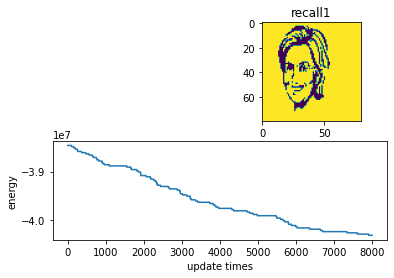

In [10]:
  #plt.show()
shape = matrix_test.shape
aa = update_asynch(weight=w_,vector=vector_test,theta = 0.5 ,times=8000)
vector_test_update = aa[0]
matrix_test_update = vector_test_update.reshape(shape)
    #matrix_test_update.shape
    #print(matrix_test_update)
plt.subplot(222)
plt.imshow(array2img(matrix_test_update))
plt.title("recall"+str(num))

    #plt.show()
plt.subplot(212)
plt.plot(aa[1],aa[2])
plt.ylabel("energy")
plt.xlabel("update times")
    
plt.show()

